# Setup

In [1]:
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)


from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import itertools
from random import randint

import IPython.display as ipd
from scipy.io import wavfile
from moviepy.editor import *
from moviepy.video.io.bindings import mplfig_to_npimage
import warnings
import librosa

import matplotlib
from matplotlib import animation
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors   
import numpy as np
import os
import cv2
import shap

import vis
from vis.visualization import visualize_saliency
from vis.utils import utils

# Writer = animation.writers['ffmpeg']
# writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
# plt.rcParams.update({'font.size': 22})

from exmatchina import *

Using TensorFlow backend.


In [2]:
num_classes = 10
sample_rate = 8000

classes = ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']


class_dict = {
    'down': 0,
    'go': 1,
    'left': 2,
    'no': 3,
    'off': 4,
    'on': 5,
    'right': 6,
    'stop': 7,
    'up': 8,
    'yes': 9
}

inv_class_dict = {v: k for k, v in class_dict.items()}

## These are the randomly generated indices that were used in our survey

# all_idx = np.array([   5,   25,  138,  153,  164,  256,  313,  413,  431,  452,  570,
#         620,  626,  646,  652,  670,  673,  712,  790,  855,  891,  919,
#         946,  995, 1027, 1032, 1044, 1047, 1080, 1091, 1151, 1164, 1165,
#        1192, 1321, 1331, 1338, 1445, 1520, 1538, 1635, 1680, 1752, 1959,
#        2008, 2090, 2091, 2108, 2160, 2259, 2272, 2291, 2292, 2363, 2399,
#        2485, 2490, 2501, 2528, 2528, 2615, 2630, 2655, 2665, 2679, 2697,
#        2699, 2711, 2757, 2841, 2909, 2958, 2995, 3009, 3060, 3168, 3191,
#        3379, 3465, 3480, 3510, 3544, 3609, 3618, 3656, 3776, 3785, 3802,
#        3815, 3838, 3982, 4013, 4069, 4076, 4136, 4141, 4157, 4195, 4203,
#        4259])
all_idx =  np.array([   5,   25,  138]) #Considering just 3 samples

# Load numpy files of data sets

In [3]:
x_train = np.load('../data/audio/X_train.npy')
y_train = np.load('../data/audio/y_train.npy')
x_test = np.load('../data/audio/X_test.npy')
y_test = np.load('../data/audio/y_test.npy')

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(17049, 8000, 1)
(17049, 10)
(4263, 8000, 1)
(4263, 10)


In [4]:
def plot(idx):
    frames = 20

    X_MIN = 0
    X_MAX = 1
    Y_MIN = x_test[idx].min()
    Y_MAX = x_test[idx].max()
    X_VALS = np.linspace(X_MIN, X_MAX, frames) # possible x values for the line

    # save test sample as wav file
    librosa.output.write_wav('./audio/' + str(idx) + '.wav', x_test[idx].ravel(), sample_rate)

    # load in the wav file
    audioclip = AudioFileClip('./audio/' + str(idx) + '.wav')
    new_audioclip = CompositeAudioClip([audioclip])

    fig, ax = plt.subplots(figsize=(16, 8))
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    l,v = ax.plot(X_MIN, Y_MIN, X_MAX, Y_MAX, linewidth=2, color='black')
    ax.plot(np.linspace(0, 1, sample_rate), x_test[idx])

    def make_frame(t):
        # ax.clear()
        x = X_VALS[int(t*frames)]
        l.set_data( [x, x], [Y_MIN, Y_MAX])

        return mplfig_to_npimage(fig)

    # create line movement animation
    animation = VideoClip(make_frame, duration=audioclip.duration)

    animation.audio = new_audioclip

    #save video
    animation.write_videofile('./audio/' + str(idx) + '.mp4', fps=frames)

    plt.close(fig)


In [5]:
for i in all_idx:
    plot(i)

Moviepy - Building video ./audio/5.mp4.
MoviePy - Writing audio in 5TEMP_MPY_wvf_snd.mp3


t:  20%|██████████████                                                        | 4/20 [00:00<00:00, 37.12it/s, now=None]

MoviePy - Done.
Moviepy - Writing video ./audio/5.mp4



Moviepy - Done !
Moviepy - video ready ./audio/5.mp4
Moviepy - Building video ./audio/25.mp4.

t:   0%|                                                                              | 0/20 [00:00<?, ?it/s, now=None]


MoviePy - Writing audio in 25TEMP_MPY_wvf_snd.mp3
MoviePy - Done.
Moviepy - Writing video ./audio/25.mp4



Moviepy - Done !
Moviepy - video ready ./audio/25.mp4
Moviepy - Building video ./audio/138.mp4.
MoviePy - Writing audio in 138TEMP_MPY_wvf_snd.mp3


t:  20%|██████████████                                                        | 4/20 [00:00<00:00, 34.27it/s, now=None]

MoviePy - Done.
Moviepy - Writing video ./audio/138.mp4



Moviepy - Done !
Moviepy - video ready ./audio/138.mp4


# Load CNN 

In [6]:
model = load_model('../trained_models/audio.hdf5')
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
Conv_1 (Conv1D)              (None, 8000, 8)           112       
_________________________________________________________________
Max_1 (MaxPooling1D)         (None, 2666, 8)           0         
_________________________________________________________________
Drop_1 (Dropout)             (None, 2666, 8)           0         
_________________________________________________________________
Conv_2

In [7]:
def calculate_metrics(model, X_test, y_test_binary):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = np.argmax(y_test_binary, axis=1)
    mismatch = np.where(y_true != y_pred)
    cf_matrix = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    #micro_f1 = f1_score(y_true, y_pred, average='micro')
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    return cf_matrix, accuracy, macro_f1, mismatch, y_pred

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        # print(cm)
    else:
        print('Confusion matrix, without normalization')
        # print(cm)

    plt.figure(figsize = (11,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize = 15)
    plt.yticks(tick_marks, classes, fontsize = 15)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 15,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    
    plt.ylabel('True label', fontsize = 12)
    plt.xlabel('Predicted label', fontsize = 12)
  

Accuracy : 0.9017124091015717
F1-score : 0.9019898563421807
Normalized confusion matrix


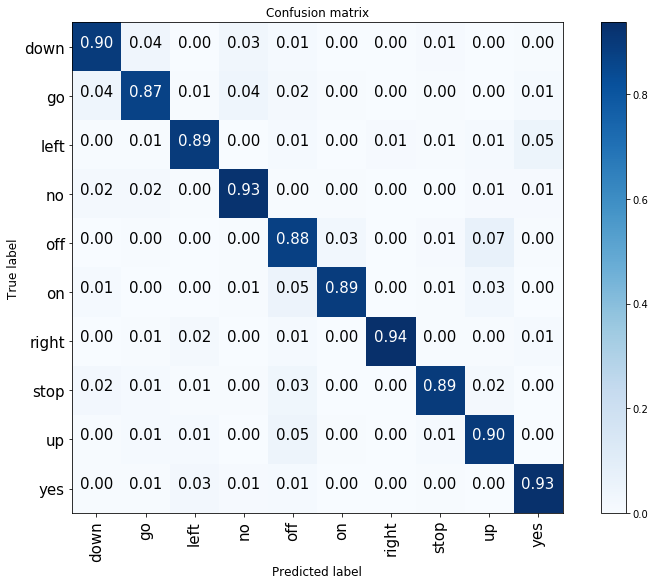

In [9]:
cf_matrix, accuracy, macro_f1, mismatch, y_pred = calculate_metrics(model, x_test, y_test)
print('Accuracy : {}'.format(accuracy))
print('F1-score : {}'.format(macro_f1))

plot_confusion_matrix(cf_matrix, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

# SHAP

In [10]:
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], x.reshape((1,) + x.shape)))
    return K.get_session().run(model.layers[layer].input, feed_dict)

def get_shap_full():
    e = shap.GradientExplainer(model, background)
    shap_values = e.shap_values(to_explain, ranked_outputs=2)
    shap.image_plot(shap_values, to_explain, width=5000, hspace='auto')


In [11]:
colors = []
for l in np.linspace(1,0,100):
    colors.append((0/255,255/255,255/255,l))
for l in np.linspace(0,1,100):
    colors.append((255/255,0/255,255/255,l))
cmm = matplotlib.colors.LinearSegmentedColormap.from_list("shap", colors)

def plot_shap(idx):
    layer = 13
    frames = 20
    X_MIN = 0
    X_MAX = 1
    Y_MIN = x_test[idx].min()
    Y_MAX = x_test[idx].max()
    X_VALS = np.linspace(X_MIN, X_MAX, frames) # possible x values for the line

    to_explain = np.expand_dims(x_test[idx], axis=0)
    e = shap.GradientExplainer((model.layers[layer].input, model.layers[-1].output), map2layer(background, layer))
    shap_values,indexes = e.shap_values(map2layer(to_explain, layer), ranked_outputs=1)

    abs_vals = np.stack(np.abs(shap_values[0].sum(-1)), 0).flatten()
    max_val = np.nanpercentile(abs_vals, 99.9)

    shap_values = cv2.resize(shap_values[0][0].sum(-1), (1,8000))
    shap_values = shap_values.reshape((8000,1))

    fig, ax = plt.subplots(figsize=(16, 8))
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    l,v = ax.plot(X_MIN, Y_MIN, X_MAX, Y_MAX, linewidth=2, color='black')
    ax.plot(np.linspace(0, 1, sample_rate), x_test[idx])

    gradient = shap_values[:,0]
    max_g = np.amax(gradient)
    min_g = np.amin(gradient)
    gradient = (gradient - min_g)/ (max_g - min_g)

    for j in range(len(gradient)):
        current_color = cmm(gradient[j])
        x = j/sample_rate
        ax.axvspan(x, x+1/sample_rate, facecolor=current_color)   

    sm = cm.ScalarMappable(cmap=cmm)
    sm.set_clim(-max_val,max_val)
    cb = fig.colorbar(sm, aspect=10)
    cb.outline.set_visible(False)

    audioclip = AudioFileClip('./audio/' + str(idx) + '.wav')
    new_audioclip = CompositeAudioClip([audioclip])

    def make_frame(t):
        x = X_VALS[int(t*frames)]
        l.set_data( [x, x], [Y_MIN, Y_MAX])

        return mplfig_to_npimage(fig)

    animation = VideoClip(make_frame, duration=audioclip.duration)

    animation.audio = new_audioclip

    animation.write_videofile('./audio/audio_' + str(idx) + '_shap.mp4', fps=frames, audio_codec='aac')

    plt.close(fig)
    

In [12]:
for i in all_idx:
    plot_shap(i)

t:   0%|                                                                              | 0/20 [00:00<?, ?it/s, now=None]

Moviepy - Building video ./audio/audio_5_shap.mp4.
MoviePy - Writing audio in audio_5_shapTEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video ./audio/audio_5_shap.mp4



Moviepy - Done !
Moviepy - video ready ./audio/audio_5_shap.mp4


t:   0%|                                                                              | 0/20 [00:00<?, ?it/s, now=None]

Moviepy - Building video ./audio/audio_25_shap.mp4.
MoviePy - Writing audio in audio_25_shapTEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video ./audio/audio_25_shap.mp4



Moviepy - Done !
Moviepy - video ready ./audio/audio_25_shap.mp4


t:   0%|                                                                              | 0/20 [00:00<?, ?it/s, now=None]

Moviepy - Building video ./audio/audio_138_shap.mp4.
MoviePy - Writing audio in audio_138_shapTEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video ./audio/audio_138_shap.mp4



Moviepy - Done !
Moviepy - video ready ./audio/audio_138_shap.mp4


# Saliency Map

In [13]:
# Saliency map requires the logits
new_model = Model(inputs=model.input,
                  outputs=model.get_layer("logits").output)
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
Conv_1 (Conv1D)              (None, 8000, 8)           112       
_________________________________________________________________
Max_1 (MaxPooling1D)         (None, 2666, 8)           0         
_________________________________________________________________
Drop_1 (Dropout)             (None, 2666, 8)           0         
_________________________________________________________________
Conv_2 (Conv1D)              (None, 2666, 16)          1424      
_________________________________________________________________
Max_2 (MaxPooling1D)         (None, 888, 16)           0         
_________________________________________________________________
Drop_2 (Dropout)             (None, 888, 16)           0     

In [14]:
def plot_map(idx, class_pred, grads):
    
    print(inv_class_dict[class_pred])
    
    frames = 20
    X_MIN = 0
    X_MAX = 1
    Y_MIN = x_test[idx].min()
    Y_MAX = x_test[idx].max()
    X_VALS = np.linspace(X_MIN, X_MAX, frames) # possible x values for the line
    
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    l,v = ax.plot(X_MIN, Y_MIN, X_MAX, Y_MAX, linewidth=2, color='black')
    ax.plot(np.linspace(0, 1, sample_rate), x_test[idx])

    gradient = grads
    max_g = np.amax(gradient)
    min_g = np.amin(gradient)
    gradient = (gradient - min_g)/ (max_g - min_g)

    for i in range(len(gradient)):
        current_color = cm.cool(gradient[i])
        x = i/sample_rate
        ax.axvspan(x, x+1/sample_rate, facecolor=current_color, alpha=0.7)

    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.90, 0.12, 0.03, 0.75])
    fig.colorbar(cm.ScalarMappable(cmap="cool"), cbar_ax, alpha=0.8)
    audioclip = AudioFileClip('./audio/' + str(idx) + '.wav')

    new_audioclip = CompositeAudioClip([audioclip])
    
    def make_frame(t):
        x = X_VALS[int(t*frames)]
        l.set_data( [x, x], [Y_MIN, Y_MAX])

        return mplfig_to_npimage(fig)

    animation = VideoClip(make_frame, duration=audioclip.duration)

    animation.audio = new_audioclip

    animation.write_videofile('./audio/audio_' + str(idx) + '_saliencymap.mp4', fps=frames, audio_codec='aac')

    plt.close(fig)

In [15]:
def getSaliencyMap(idx):
#   with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
    to_explain = np.expand_dims(x_test[idx],axis=0)
    class_pred = np.argmax(model.predict(to_explain))

    grads = visualize_saliency(new_model,
                                13,
                                filter_indices = None,
                                seed_input = x_test[idx])
    plot_map(idx, class_pred , grads)

In [16]:
for i in all_idx:
    getSaliencyMap(i)


on


t:   0%|                                                                              | 0/20 [00:00<?, ?it/s, now=None]

Moviepy - Building video ./audio/audio_5_saliencymap.mp4.
MoviePy - Writing audio in audio_5_saliencymapTEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video ./audio/audio_5_saliencymap.mp4



Moviepy - Done !
Moviepy - video ready ./audio/audio_5_saliencymap.mp4
no


t:   0%|                                                                              | 0/20 [00:00<?, ?it/s, now=None]

Moviepy - Building video ./audio/audio_25_saliencymap.mp4.
MoviePy - Writing audio in audio_25_saliencymapTEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video ./audio/audio_25_saliencymap.mp4



Moviepy - Done !
Moviepy - video ready ./audio/audio_25_saliencymap.mp4
up


t:   0%|                                                                              | 0/20 [00:00<?, ?it/s, now=None]

Moviepy - Building video ./audio/audio_138_saliencymap.mp4.
MoviePy - Writing audio in audio_138_saliencymapTEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video ./audio/audio_138_saliencymap.mp4



Moviepy - Done !
Moviepy - video ready ./audio/audio_138_saliencymap.mp4


# Grad-Cam++

In [17]:
def normalize(x):
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def plot_cam(idx, class_idx, heatmap):

    frames = 20
    X_MIN = 0
    X_MAX = 1
    Y_MIN = x_test[idx].min()
    Y_MAX = x_test[idx].max()
    X_VALS = np.linspace(X_MIN, X_MAX, frames) # possible x values for the line

    fig, ax = plt.subplots(figsize=(16, 8))
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    l,v = ax.plot(X_MIN, Y_MIN, X_MAX, Y_MAX, linewidth=2, color='black')
    ax.plot(np.linspace(0, 1, sample_rate), x_test[idx])

    gradient = heatmap.reshape((8000,))
    max_g = np.amax(gradient)
    min_g = np.amin(gradient)
    gradient = (gradient - min_g)/ (max_g - min_g)

    for i in range(len(gradient)):
        current_color = cm.cool(gradient[i])
        x = i/sample_rate
        ax.axvspan(x, x+1/sample_rate, facecolor=current_color, alpha=0.7)

    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.90, 0.12, 0.03, 0.75])
    fig.colorbar(cm.ScalarMappable(cmap="cool"), cbar_ax, alpha=0.8)

    audioclip = AudioFileClip('./audio/' + str(idx) + '.wav')

    new_audioclip = CompositeAudioClip([audioclip])

    def make_frame(t):
        # ax.clear()
        x = X_VALS[int(t*frames)]
        l.set_data( [x, x], [Y_MIN, Y_MAX])

        return mplfig_to_npimage(fig)

    animation = VideoClip(make_frame, duration=audioclip.duration)

    animation.audio = new_audioclip

    animation.write_videofile('./audio/audio_' + str(idx) + '_gradcampp.mp4', fps=frames,audio_codec='aac')

    plt.close(fig)

def get_gradcampp(idx):
    img = x_test[idx]
    class_idx = np.argmax(y_test[idx])
    
    # for cam
    x = np.expand_dims(img, axis=0)

    # cam / superimpose
    cls_pred, cam = grad_cam_plus_plus(input_model=model, x=x, layer_name="Conv_5")
    heatmap = cv2.resize(cam, (1,8000))
    heatmap = heatmap.reshape((8000,1))

    plot_cam(idx,class_idx, heatmap)

def grad_cam_plus_plus(input_model, x, layer_name):
    cls = np.argmax(model.predict(x))
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = normalize(K.gradients(y_c, conv_output)[0])

    first = K.exp(y_c) * grads
    second = K.exp(y_c) * grads * grads
    third = K.exp(y_c) * grads * grads * grads

    gradient_function = K.function([model.input], [y_c, first, second, third, conv_output, grads])
    y_c, conv_first_grad, conv_second_grad, conv_third_grad, conv_output, grads_val = gradient_function([x])
    global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[1])), axis=0)

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0] * 2.0 + conv_third_grad[0] * global_sum.reshape((1, 1, conv_first_grad[0].shape[1]))
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))

    alphas = alpha_num / alpha_denom # 0

    weights = np.maximum(conv_first_grad[0], 0.0)
    alpha_normalization_constant = np.sum(np.sum(alphas, axis=0), axis=0) # 0
    alphas /= alpha_normalization_constant.reshape((1, 1, conv_first_grad[0].shape[1])) # NAN
    deep_linearization_weights = np.sum((weights * alphas).reshape((-1, conv_first_grad[0].shape[1])), axis=0)

    cam = np.sum(deep_linearization_weights * conv_output[0], axis=1)

    cam = np.maximum(cam, 0) 
    if cam.max() == 0:
        print(idx)
    cam /= cam.max() 

    return cls, cam

In [18]:
for i in all_idx:
    get_gradcampp(i)

t:   0%|                                                                              | 0/20 [00:00<?, ?it/s, now=None]

Moviepy - Building video ./audio/audio_5_gradcampp.mp4.
MoviePy - Writing audio in audio_5_gradcamppTEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video ./audio/audio_5_gradcampp.mp4



Moviepy - Done !
Moviepy - video ready ./audio/audio_5_gradcampp.mp4


t:   0%|                                                                              | 0/20 [00:00<?, ?it/s, now=None]

Moviepy - Building video ./audio/audio_25_gradcampp.mp4.
MoviePy - Writing audio in audio_25_gradcamppTEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video ./audio/audio_25_gradcampp.mp4



Moviepy - Done !
Moviepy - video ready ./audio/audio_25_gradcampp.mp4


t:   0%|                                                                              | 0/20 [00:00<?, ?it/s, now=None]

Moviepy - Building video ./audio/audio_138_gradcampp.mp4.
MoviePy - Writing audio in audio_138_gradcamppTEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video ./audio/audio_138_gradcampp.mp4



Moviepy - Done !
Moviepy - video ready ./audio/audio_138_gradcampp.mp4


# Examples

In [19]:
def plot_audio(audio, filename):
    frames = 20
    sample_rate = 8000

    X_MIN = 0
    X_MAX = 1
    Y_MIN = audio.min()
    Y_MAX = audio.max()
    X_VALS = np.linspace(X_MIN, X_MAX, frames) # possible x values for the line

    librosa.output.write_wav('./audio/' + str(filename) + '.wav', audio.ravel(), sample_rate)

    audioclip = AudioFileClip('./audio/' + str(filename) + '.wav')
    new_audioclip = CompositeAudioClip([audioclip])

    fig, ax = plt.subplots(figsize=(16, 8))
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    l,v = ax.plot(X_MIN, Y_MIN, X_MAX, Y_MAX, linewidth=2, color='black')
    ax.plot(np.linspace(0, 1, sample_rate), audio)

    def make_frame(t):
        # ax.clear()
        x = X_VALS[int(t*frames)]
        l.set_data( [x, x], [Y_MIN, Y_MAX])

        return mplfig_to_npimage(fig)

    animation = VideoClip(make_frame, duration=audioclip.duration)

    animation.audio = new_audioclip

    animation.write_videofile('./audio/' + str(filename) + '.mp4', fps=frames, audio_codec='aac')

    plt.close(fig)


In [20]:
selected_layer = 'flatten_2'

exm = ExMatchina(model=model, layer=selected_layer, examples=x_train)

Getting activations...
Getting labels...
Generating activation matrix...


In [21]:
for test_idx in all_idx:
    test_input = x_test[test_idx]
    label = exm.get_label_for(test_input)
    (examples, indices) = exm.return_nearest_examples(test_input)
    
    plot_audio(test_input, "audio_" + str(test_idx))
    plot_audio(examples[0], "audio_" + str(test_idx) + "_example1")
    plot_audio(examples[1], "audio_" + str(test_idx) + "_example2")
    plot_audio(examples[2], "audio_" + str(test_idx) + "_example3")

t:   0%|                                                                              | 0/20 [00:00<?, ?it/s, now=None]

Moviepy - Building video ./audio/audio_5.mp4.
MoviePy - Writing audio in audio_5TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video ./audio/audio_5.mp4



chunk:   0%|                                                                          | 0/23 [00:00<?, ?it/s, now=None]

Moviepy - Done !
Moviepy - video ready ./audio/audio_5.mp4
Moviepy - Building video ./audio/audio_5_example1.mp4.
MoviePy - Writing audio in audio_5_example1TEMP_MPY_wvf_snd.mp4


t:  20%|██████████████                                                        | 4/20 [00:00<00:00, 34.57it/s, now=None]

MoviePy - Done.
Moviepy - Writing video ./audio/audio_5_example1.mp4



Moviepy - Done !
Moviepy - video ready ./audio/audio_5_example1.mp4


t:   0%|                                                                              | 0/20 [00:00<?, ?it/s, now=None]

Moviepy - Building video ./audio/audio_5_example2.mp4.
MoviePy - Writing audio in audio_5_example2TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video ./audio/audio_5_example2.mp4



Moviepy - Done !
Moviepy - video ready ./audio/audio_5_example2.mp4
Moviepy - Building video ./audio/audio_5_example3.mp4.
MoviePy - Writing audio in audio_5_example3TEMP_MPY_wvf_snd.mp4


t:  15%|██████████▌                                                           | 3/20 [00:00<00:00, 26.86it/s, now=None]

MoviePy - Done.
Moviepy - Writing video ./audio/audio_5_example3.mp4



Moviepy - Done !
Moviepy - video ready ./audio/audio_5_example3.mp4


t:   0%|                                                                              | 0/20 [00:00<?, ?it/s, now=None]

Moviepy - Building video ./audio/audio_25.mp4.
MoviePy - Writing audio in audio_25TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video ./audio/audio_25.mp4



Moviepy - Done !
Moviepy - video ready ./audio/audio_25.mp4
Moviepy - Building video ./audio/audio_25_example1.mp4.
MoviePy - Writing audio in audio_25_example1TEMP_MPY_wvf_snd.mp4


t:  20%|██████████████                                                        | 4/20 [00:00<00:00, 33.41it/s, now=None]

MoviePy - Done.
Moviepy - Writing video ./audio/audio_25_example1.mp4



Moviepy - Done !
Moviepy - video ready ./audio/audio_25_example1.mp4
Moviepy - Building video ./audio/audio_25_example2.mp4.
MoviePy - Writing audio in audio_25_example2TEMP_MPY_wvf_snd.mp4


t:  20%|██████████████                                                        | 4/20 [00:00<00:00, 32.34it/s, now=None]

MoviePy - Done.
Moviepy - Writing video ./audio/audio_25_example2.mp4



Moviepy - Done !
Moviepy - video ready ./audio/audio_25_example2.mp4
Moviepy - Building video ./audio/audio_25_example3.mp4.
MoviePy - Writing audio in audio_25_example3TEMP_MPY_wvf_snd.mp4


t:  20%|██████████████                                                        | 4/20 [00:00<00:00, 31.09it/s, now=None]

MoviePy - Done.
Moviepy - Writing video ./audio/audio_25_example3.mp4



Moviepy - Done !
Moviepy - video ready ./audio/audio_25_example3.mp4


t:   0%|                                                                              | 0/20 [00:00<?, ?it/s, now=None]

Moviepy - Building video ./audio/audio_138.mp4.
MoviePy - Writing audio in audio_138TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video ./audio/audio_138.mp4



chunk:   0%|                                                                          | 0/23 [00:00<?, ?it/s, now=None]

Moviepy - Done !
Moviepy - video ready ./audio/audio_138.mp4
Moviepy - Building video ./audio/audio_138_example1.mp4.
MoviePy - Writing audio in audio_138_example1TEMP_MPY_wvf_snd.mp4


t:  20%|██████████████                                                        | 4/20 [00:00<00:00, 35.18it/s, now=None]

MoviePy - Done.
Moviepy - Writing video ./audio/audio_138_example1.mp4



Moviepy - Done !
Moviepy - video ready ./audio/audio_138_example1.mp4
Moviepy - Building video ./audio/audio_138_example2.mp4.

t:   0%|                                                                              | 0/20 [00:00<?, ?it/s, now=None]


MoviePy - Writing audio in audio_138_example2TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video ./audio/audio_138_example2.mp4



chunk:   0%|                                                                          | 0/23 [00:00<?, ?it/s, now=None]

Moviepy - Done !
Moviepy - video ready ./audio/audio_138_example2.mp4
Moviepy - Building video ./audio/audio_138_example3.mp4.
MoviePy - Writing audio in audio_138_example3TEMP_MPY_wvf_snd.mp4


t:  20%|██████████████                                                        | 4/20 [00:00<00:00, 33.97it/s, now=None]

MoviePy - Done.
Moviepy - Writing video ./audio/audio_138_example3.mp4



Moviepy - Done !
Moviepy - video ready ./audio/audio_138_example3.mp4
